In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expit, logit

# Data Description and Causal Graph

(graph generation code commented out to avoid potential issues with dependencies)

We create one outcome of interest:

Feature Name | Type | Details 
:--- |:--- |:--- 
**Revenue** | continuous | \\$ Annual revenue from customer given by the amount of software purchased

We consider three possible treatments, the interventions whose impact we wish to measure:

Feature Name | Type | Details 
:--- |:--- |:--- 
**Tech Support** | binary | whether the customer received tech support during the year
**Discount** | binary | whether the customer was given a discount during the year
**New Strategy** | binary | whether the customer was targeted for a new engagement strategy with different outreach behaviors

Finally, we consider a variety of additional customer characteristics that may affect revenue. Including these types of features is crucial for causal analysis in order to map the full causal graph and separate the true effects of treatments on outcomes from other correlation generated by other influences. 

Feature Name | Type | Details 
:--- |:--- |:--- 
**Global Flag** | binary | whether the customer has global offices
**Major Flag** | binary | whether the customer is a large consumer in their industry (as opposed to SMC - Small Medium Corporation - or SMB - Small Medium Business)
**SMC Flag** | binary | whether the customer is a Small Medium Corporation (SMC, as opposed to major and SMB)
**Commercial Flag** | binary | whether the customer's business is commercial (as opposed to public secor)
**Planning Summit** | binary | whether a sales team member held an outreach event with the customer during the year
**New Product Adoption** | binary | whether the customer signed a contract for any new products during the year
**IT Spend** | continuous | \\$ spent on IT-related purchases 
**Employee Count** | continuous | number of employees
**PC Count** | continuous | number of PCs used by the customer
**Size** | continuous | customer's total revenue in the previous calendar year

In simulating the data, we maintain some key characteristics of the data from the real company example, including some correlation patterns between features and some potentially difficult data characteristics, such as large outliers.

In [2]:
# import networkx as nx
# import dowhy.gcm

# ynode="Revenue"
# mednode="New Product Adoption"
# collider="Planning Summit"
# T_cols = ["Tech Support", "Discount", "New Engagement Strategy"]
# trueg = nx.DiGraph()
# trueg.nodes=new_df.loc[:, 'Global Flag':'Revenue'].columns
# trueg.add_edges_from([(w, "Revenue") for w in W_cols])
# trueg.add_edges_from([(x, "Revenue") for x in X_cols]) # effect modifiers
# for t in T_cols:
#     trueg.add_edges_from([(w, t) for w in W_cols])
#     trueg.add_edge(t, ynode)
# trueg.add_edge(T_cols[0], mednode); trueg.add_edge(mednode, ynode) # mediator
# trueg.add_edge(T_cols[2], collider);trueg.add_edge(ynode, collider);   # collider

# dowhy.gcm.util.plot(trueg, figure_size=(20,20))

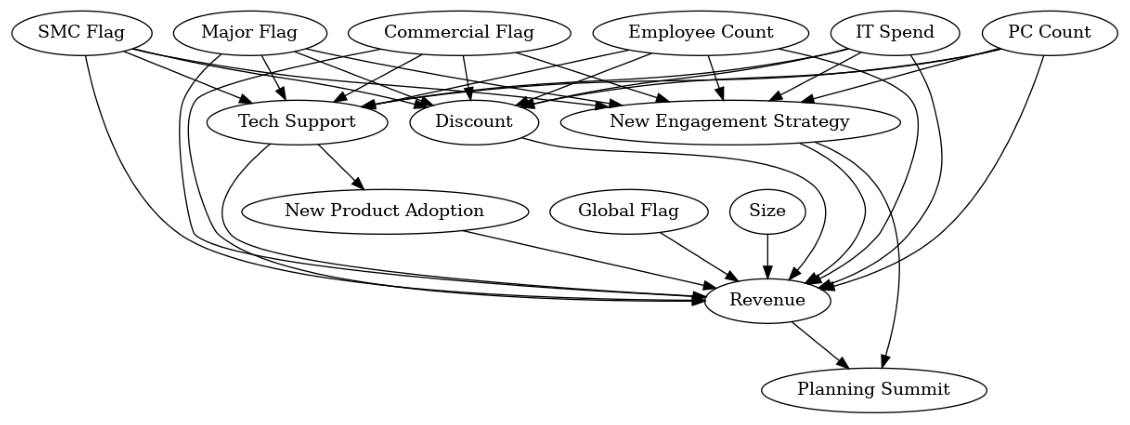

# Data Generation

#### Generate covariates W, X.

Most features are independent but some are correlated.

In [3]:
np.random.seed(1)

n = 50000

global_flag = np.random.binomial(n = 1, p = 0.2, size = n)
major_flag = np.random.binomial(n = 1, p = 0.2, size = n)
smc_flag = np.random.binomial(n = 1, p = 0.5, size = n)
commercial_flag = np.random.binomial(n = 1, p = 0.7, size = n)

size = np.random.exponential(scale = 100000, size = n) + np.random.uniform(low = 5000, high = 15000, size = n)
it_spend = np.exp(np.log(size) - 1.4 + np.random.uniform(size = n))

pc_count = np.random.exponential(scale = 50, size = n) + np.random.uniform(low = 5, high = 10, size = n)
employee_count = np.exp(np.log(pc_count)*0.9 + 0.4 + np.random.uniform(size = n))

size = size.astype(int)
it_spend = it_spend.astype(int)
pc_count = pc_count.astype(int)
employee_count = employee_count.astype(int)


new_X = pd.DataFrame(
    {
        'Global Flag': global_flag,
        'Major Flag': major_flag,
        'SMC Flag': smc_flag,
        'Commercial Flag': commercial_flag,
        'IT Spend': it_spend,
        'Employee Count': employee_count,
        'PC Count': pc_count,
        'Size': size
    }
)

#### Generate treatment from covariates

In [4]:
# controls
W_cols = ['Major Flag', 'SMC Flag', 'Commercial Flag', 'IT Spend', 'Employee Count', 'PC Count']

# Tech Support
coefs_W_tech = np.array([0, 0, 0, 0.00001, 0, 0])
const_tech = -0.465
noise_tech = np.random.normal(scale=2.0, size = n)
z_tech = new_X[W_cols] @ coefs_W_tech + const_tech + noise_tech
prob_tech = expit(z_tech)
tech_support = np.random.binomial(n = 1, p = prob_tech, size = n)

# Discount
coefs_W_discount = np.array([0.2, 0, 0, 0.000005, 0, 0])
const_discount = -0.27
noise_discount = np.random.normal(scale=1.5, size = n)
z_discount = new_X[W_cols] @ coefs_W_discount + const_discount + noise_discount
prob_discount = expit(z_discount)
discount = np.random.binomial(n = 1, p = prob_discount, size = n)

# New Engagement Strategy
coefs_W_t3 = np.array([0.5, 0.1, -0.2, 0, 0.005, -0.005])
const_t3 = -0.12
noise_t3 = np.random.normal(scale=1.0, size = n)
z_t3 = new_X[W_cols] @ coefs_W_t3 + const_t3 + noise_t3
prob_t3 = expit(z_t3)
t3 = np.random.binomial(n = 1, p = prob_t3, size = n)

#### Mediator

generated from Tech Support

In [5]:
z_m = tech_support*2-1 + np.random.normal(size=n)
prob_m = expit(z_m)
m = np.random.binomial(n = 1, p = prob_m, size = n)

#### Outcome

In [6]:
# X features determine heterogeneous treatment effects
X_cols = ['Global Flag', 'Size']
theta_coef_tech_support = [500, 0.02]
theta_const_tech_support = 5000
te_tech_support = new_X[X_cols] @ theta_coef_tech_support + theta_const_tech_support

theta_coef_discount = [-1000, 0.05]
theta_const_discount = 0
te_discount = new_X[X_cols] @ theta_coef_discount + theta_const_discount

theta_coef_t3 = [0, 0]
theta_const_t3 = 0
te_t3 = new_X[X_cols] @ theta_coef_t3 + theta_const_t3

y_te = te_tech_support*tech_support + te_discount*discount + te_t3*t3

g_coefs = np.array([2000, 0, 5000, 0.25, 0.0001, 0.0001])
g_const = 5000
g_y = new_X[W_cols] @ g_coefs + g_const

y_noise = np.random.normal(scale = 1000, size = n)

mediator_effect = 2000*m

y = pd.Series(y_te + g_y + y_noise + mediator_effect)

#### Collider

Caused by both outcome and New Engagement Strategy

In [7]:
z_c = 0.03*y + 1000*t3 - 1400
prob_c = expit(z_c)
c = np.random.binomial(n = 1, p = prob_c, size = n)

## Consolidate

In [8]:
new_df = (
    pd.concat(
        [
            new_X,
            pd.DataFrame(
                {
                    'Tech Support': tech_support,
                    'Discount': discount,
                    'New Engagement Strategy': t3,
                    'New Product Adoption': m,
                    'Planning Summit': c,
                    'Revenue': y,
                    'Direct Treatment Effect: Tech Support': te_tech_support,
                    'Total Treatment Effect: Tech Support': np.round(te_tech_support + (expit(1) - expit(-1))*2000, decimals=2), # incorporate effect from mediator into total effect.
                    'Direct Treatment Effect: Discount': te_discount,
                    'Total Treatment Effect: Discount': te_discount,
                    'Direct Treatment Effect: New Engagement Strategy': te_t3,
                    'Total Treatment Effect: New Engagement Strategy': te_t3,
                }
            )
        ],
        axis = 1,
    )
    .assign(Revenue = lambda df: df['Revenue'].round(2))
)

#### write to csv 

In [9]:
(
    new_df
    .to_csv('multi_attribution_data.csv', index = False)
)

#### Ground Truth ATE check 

In [10]:
new_df.filter(like='Treatment Effect').mean(axis=0)

Direct Treatment Effect: Tech Support               7296.320288
Total Treatment Effect: Tech Support                8220.550288
Direct Treatment Effect: Discount                   5292.150720
Total Treatment Effect: Discount                    5292.150720
Direct Treatment Effect: New Engagement Strategy       0.000000
Total Treatment Effect: New Engagement Strategy        0.000000
dtype: float64

# Data checks (optional)

Compare newly generated data against an older version of the data.

In [11]:
# Import the sample multi-attribution data
file_url = "https://msalicedatapublic.blob.core.windows.net/datasets/ROI/multi_attribution_sample.csv"
multi_data = pd.read_csv(file_url)

In [12]:
df_dict = {'New Dataset': new_df, 'Old Dataset': multi_data}

#### X, W Distribution

binary vars, count occurences for each unique value

In [13]:
for key in df_dict:
    df = df_dict[key]
    print(key)
    display(
        df
        [['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag']]
        .apply(pd.Series.value_counts)
    )

New Dataset


,Global Flag,Major Flag,SMC Flag,Commercial Flag
0,40030,39982,24884,15094
1,9970,10018,25116,34906


Old Dataset


,Global Flag,Major Flag,SMC Flag,Commercial Flag
0,1596,1610,991,618
1,404,390,1009,1382


continuous vars

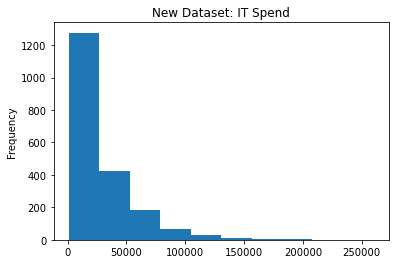

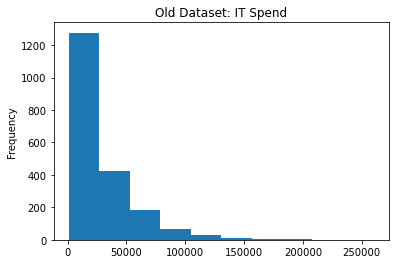

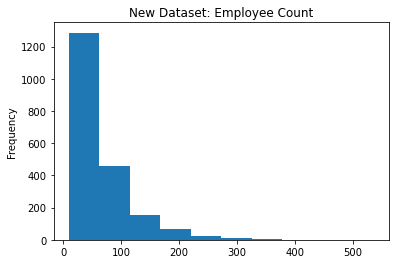

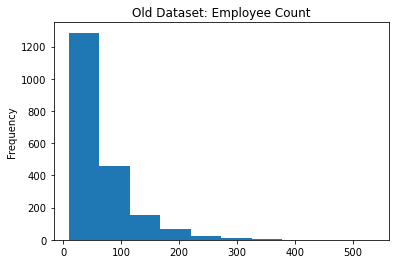

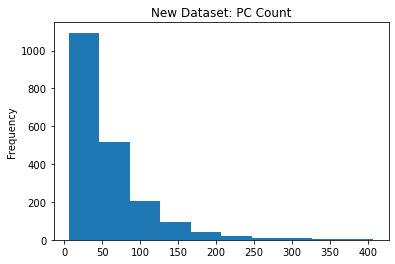

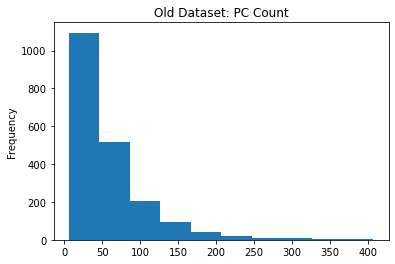

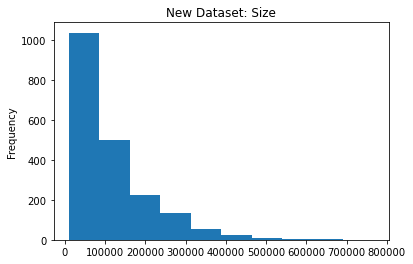

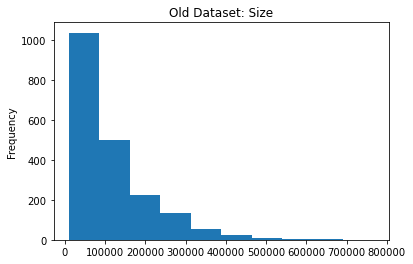

In [14]:
for col_name in ['IT Spend', 'Employee Count', 'PC Count', 'Size']:
    for key in df_dict:
        plt.figure()
        ax = df[col_name].plot.hist(title = key + ': ' + col_name)
        

sensible minimums for IT Spend, Employee Count, PC Count, Size 

In [15]:
for key in df_dict:
    df = df_dict[key]
    print(key)
    display(
        df
        [['IT Spend', 'Employee Count', 'PC Count', 'Size']]
        .apply(pd.Series.min)
        .to_frame('Minimum value')
    )

New Dataset


,Minimum value
IT Spend,1443
Employee Count,6
PC Count,5
Size,5249


Old Dataset


,Minimum value
IT Spend,1161
Employee Count,10
PC Count,6
Size,10101


##### patterns 

IT Spend vs Size

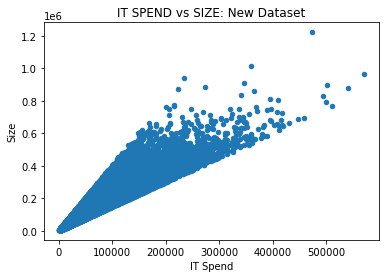

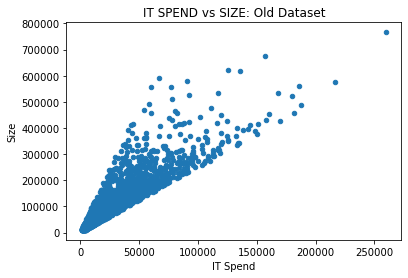

In [16]:
for key in df_dict:
    df = df_dict[key]
    (
        df
        .plot.scatter(x = 'IT Spend', y = 'Size', title = 'IT SPEND vs SIZE: ' + key)
    )

Employee Count vs PC Count

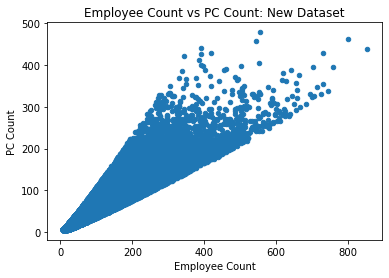

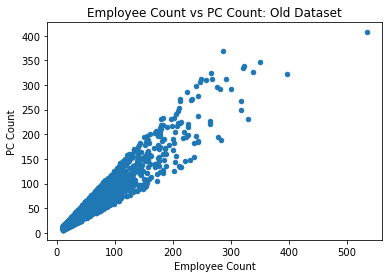

In [17]:
for key in df_dict:
    df = df_dict[key]
    (
        df
        .plot.scatter(x = 'Employee Count', y = 'PC Count', title = 'Employee Count vs PC Count: ' + key)
    )

#### Treatment distribution 

value counts for each treatment

In [18]:
for key in df_dict:
    df = df_dict[key]
    print(key)
    display(
        df
        .reindex(['Tech Support', 'Discount'], axis = 1)
        .apply(pd.Series.value_counts)
    )

New Dataset


,Tech Support,Discount
1,25092,25008
0,24908,24992


Old Dataset


,Tech Support,Discount
1,1006,1021
0,994,979


##### patterns 

treatment correlated with size

In [19]:
for key in df_dict:
    df = df_dict[key]
    print(key)
    display(
        df
        .groupby(
            ['Tech Support', 'Discount'],
            as_index = False
        )
        ['Size']
        .mean()
        .rename(columns = {'Size': 'Avg Size'})
        .astype(int)
    )

New Dataset


,Tech Support,Discount,Avg Size
0,0,0,91648
1,0,1,102870
2,1,0,114011
3,1,1,130562


Old Dataset


,Tech Support,Discount,Avg Size
0,0,0,70943
1,0,1,96466
2,1,0,108978
3,1,1,171466


#### Y 

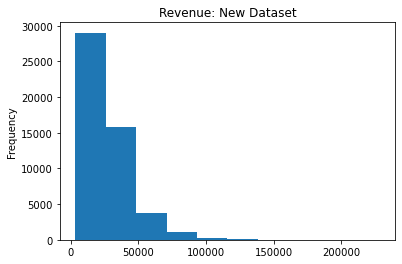

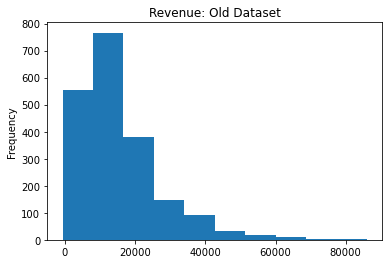

In [20]:
for key in df_dict:
    df = df_dict[key]
    plt.figure()
    df['Revenue'].plot.hist(title = 'Revenue: ' + key)
